In [1]:
import tensorflow as tf
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping
import time
# from keras.utils.np_utils import to_categorical
from tensorflow.python.keras.utils.np_utils import to_categorical
# from tensorflow.python.keras.utils import to_categorical

import shap
from tensorflow.python.ops import gradients_impl as tf_gradients_impl
tf_gradients_impl._IsBackpropagatable=True

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.python.keras import layers, losses
from tensorflow.python.keras.datasets import fashion_mnist
from tensorflow.python.keras.models import Model

from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder
from tensorflow.python.keras.layers import InputLayer
from sklearn.preprocessing import OneHotEncoder

from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input, Dense, Layer, InputSpec
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras import regularizers, activations, initializers, constraints, Sequential
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.constraints import UnitNorm, Constraint

In [2]:
# from tensorflow.python.keras.utils import to_categorical

In [3]:
class DenseTied(Layer):
    def __init__(self, units,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 tied_to=None,
                 **kwargs):
        self.tied_to = tied_to
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super().__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True
                
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        if self.tied_to is not None:
            self.kernel = K.transpose(self.tied_to.kernel)
            self._non_trainable_weights.append(self.kernel)
        else:
            self.kernel = self.add_weight(shape=(input_dim, self.units),
                                          initializer=self.kernel_initializer,
                                          name='kernel',
                                          regularizer=self.kernel_regularizer,
                                          constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def call(self, inputs):
        output = K.dot(inputs, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

class WeightsOrthogonalityConstraint (Constraint):
    def __init__(self, encoding_dim, weightage = 1.0, axis = 0):
        self.encoding_dim = encoding_dim
        self.weightage = weightage
        self.axis = axis
        
    def weights_orthogonality(self, w):
        if(self.axis==1):
            w = K.transpose(w)
        if(self.encoding_dim > 1):
            m = K.dot(K.transpose(w), w) - K.eye(self.encoding_dim)
            return self.weightage * K.sqrt(K.sum(K.square(m)))
        else:
            m = K.sum(w ** 2) - 1.
            return m

    def __call__(self, w):
        return self.weights_orthogonality(w)
    
class UncorrelatedFeaturesConstraint(Constraint):
    
    def __init__(self, encoding_dim, weightage = 1.0):
        self.encoding_dim = encoding_dim
        self.weightage = weightage
    
    def get_covariance(self, x):
        x_centered_list = []

        for i in range(self.encoding_dim):
            x_centered_list.append(x[:, i] - K.mean(x[:, i]))
        
        x_centered = tf.stack(x_centered_list)
        covariance = K.dot(x_centered, K.transpose(x_centered)) / tf.cast(x_centered.get_shape()[0], tf.float32)
        
        return covariance
            
    # Constraint penalty
    def uncorrelated_feature(self, x):
        if(self.encoding_dim <= 1):
            return 0.0
        else:
#             output = K.sum(K.square(
#                 self.covariance - tf.matmul(self.covariance, K.eye(self.encoding_dim))))
            output = tf.reduce_sum(tf.square(
                self.covariance - tf.matmul(self.covariance, tf.eye(self.encoding_dim))))            
            
            # FIXED ???
         # still don't know what the problem is here!
# https://stackoverflow.com/questions/57836849/tensorflow-keras-custom-constraint-not-working        
# https://stackoverflow.com/questions/53751024/tying-autoencoder-weights-in-a-dense-keras-layer        
        
            # tf.math.multiply
            return output

    def __call__(self, x):
        self.covariance = self.get_covariance(x)
        return self.weightage * self.uncorrelated_feature(x)   
    
def extract_layers(main_model, starting_layer_ix, ending_layer_ix, input_shape):
  # create an empty model
    new_model = Sequential()
    first_layer =True
    for ix in range(starting_layer_ix, ending_layer_ix + 1):
        curr_layer = main_model.get_layer(index=ix)
        # copy this layer over to the new model
        if first_layer:
            new_model.add(input_shape)
            first_layer=False
        new_model.add(curr_layer)
    return new_model    

In [4]:
import keras.backend as K
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return 1 - numerator / denominator

def balanced_cross_entropy(y_true, y_pred):
    
    beta = beta = tf.reduce_mean(1 - y_true)
    weight_a = beta * tf.cast(y_true, tf.float32)
    weight_b = (1 - beta) * tf.cast(1 - y_true, tf.float32)

    o = (tf.math.log1p(tf.exp(-tf.abs(y_pred))) + tf.nn.relu(-y_pred)) * (weight_a + weight_b) + y_pred * weight_b
    return tf.reduce_mean(o)

In [5]:
# %%time
# dataset_name = "W20_only"
# df_list = "BES_Panel"

# %matplotlib inline 
# %run BES_header.py {dataset_name} {df_list}
# (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)    
# # get full set of inferred "cross wave" auth-lib/left-right values and ages
# # pan_dataset_allr_values = pd.read_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip",compression='zip')
# # # pan_dataset_allr_values = pan_dataset_allr_values.loc[BES_Panel.index].sort_index()
# # pan_dataset_ages = pd.read_pickle(BES_small_data_files + "pan_dataset_ages"+".zip", compression='zip')
# # pan_dataset_votes = pd.read_pickle(BES_small_data_files+"pan_dataset_votes"+".zip",compression='zip')


In [6]:
# from tensorflow.python.keras.layers import Multiply

In [7]:
# import numpy as np
# import pandas as pd
# %matplotlib inline
# import matplotlib.pyplot as plt
# import gc
# import re

# from itertools import cycle
# from IPython.display import display
# import pickle, os

# import seaborn as sns

# encoding = "ISO-8859-1"

# import Jupyter_module_loader

In [8]:
# import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
# import pickle, os, gc, re

# from IPython.display import display

# import Jupyter_module_loader
# # from utility import *

In [9]:
%%time
dataset_name = "W10_only"
df_list = "BES_reduced"

%matplotlib inline 
%run BES_header.py {dataset_name} {df_list}
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)    
# get full set of inferred "cross wave" auth-lib/left-right values and ages
pan_dataset_allr_values = pd.read_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip",compression='zip')
# pan_dataset_allr_values = pan_dataset_allr_values.loc[BES_Panel.index].sort_index()
pan_dataset_ages = pd.read_pickle(BES_small_data_files + "pan_dataset_ages"+".zip", compression='zip')
pan_dataset_votes = pd.read_pickle(BES_small_data_files+"pan_dataset_votes"+".zip",compression='zip')


Toggle code

var_type (354, 13)
Wall time: 1.83 s


In [10]:
# warnings - don't know why, online comments suggest just blocking
# tf.logging.set_verbosity(tf.logging.ERROR)

In [11]:
drop_vars = []
drop_vars.extend( [x for x in BES_reduced.columns if "eurefvote" in x.lower() ] )
drop_vars.extend( [x for x in BES_reduced.columns if "euid_" in x.lower() ] )
drop_vars.extend( [x for x in BES_reduced.columns if "happyeuleave" in x.lower() ] )
drop_vars                 

['profile_eurefvote_Leave the EU',
 'euRefVote_Leave the EU',
 'euID_The leave side',
 'happyEULeave__Extremely happy']

In [12]:
# [x for x in BES_reduced.columns if "euref" in x.lower()]
y = BES_reduced['euRefVote_Leave the EU']
X = BES_reduced.drop(drop_vars,axis=1)
y = to_categorical(y)

In [13]:
# X.shape

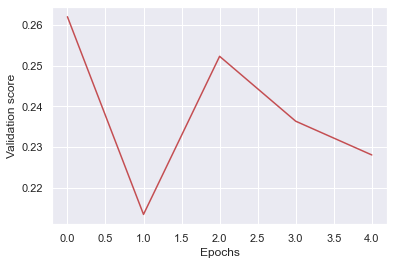

22.731377124786377


In [14]:
start_time = time.time()

early_stopping_monitor = EarlyStopping(patience=3)

n_neurons_layer = 500

# Create the model: model
model = Sequential()

# Add the first hidden layer
input_shape = (X.shape[1],)
model.add( Dense(n_neurons_layer, activation='relu', input_shape = input_shape) )

# Add the second hidden layer
model.add( Dense(n_neurons_layer, activation='relu') )

# Add the third hidden layer
model.add( Dense(n_neurons_layer, activation='relu') )

# Add the fourth hidden layer
model.add( Dense(n_neurons_layer, activation='relu') )

# Add the output layer
no_of_outputs = len(np.unique(y))
model.add( Dense( no_of_outputs , activation='softmax') )

# Compile the model
model.compile( optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Fit the model
# X -> X.values
model_training = model.fit(X.values, y, epochs=15, validation_split=0.2, callbacks=[early_stopping_monitor], verbose=False)

# Create the plot
plt.plot(model_training.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

elapsed_time = time.time() - start_time
print(elapsed_time)

In [15]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
print(tf.test.is_built_with_cuda())

True


In [17]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1



In [18]:
# select a set of background examples to take an expectation over
background = X.loc[np.random.choice(X.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background.values)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(X.loc[1:5].values)

# plot the feature attributions
# shap.image_plot(shap_values, -X.loc[1:5])

In [19]:
tf.__version__
## super old

'2.5.0'

In [20]:
shap.__version__
### latesty

'0.39.0'

In [21]:
%%time

# hasattr(tf_gradients_impl, "_IsBackpropagatable")
background = X.loc[np.random.choice(X.shape[0], 200, replace=False)]

# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
e = shap.DeepExplainer(model, background.values)
shap_values = e.shap_values(background.values)

Wall time: 2.42 s


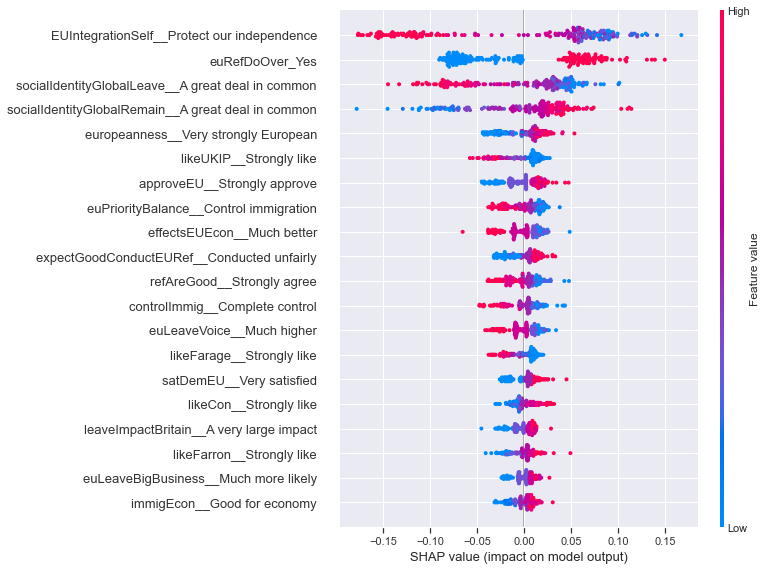

Wall time: 418 ms


In [22]:
%%time
shap.summary_plot(shap_values[0], background, plot_type='dot')

0.39.0 
 2.5.0


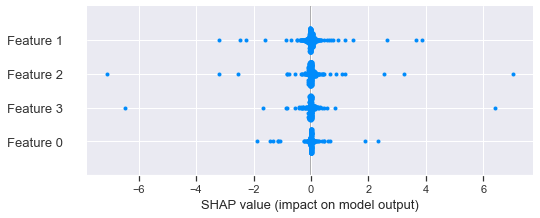

In [23]:
from numpy.random import randint
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.optimizers import Adam
import shap
import tensorflow
print(shap.__version__, "\n",tensorflow.__version__)

# Train_x data creation
train_x = pd.DataFrame({
    'v1': randint(2, 20, 1489),
    'v2': randint(50, 200, 1489),
    'v3': randint(30, 90, 1489),
    'v4': randint(100, 150, 1489)
})

# Train_y data creation
train_y = randint(0, 2, 1489)

# One-hot encoding as I use categorical cross-entropy
train_y = to_categorical(train_y, num_classes=2)

# Start construction of a DNN Sequential model.
model = Sequential()

# First input layer with a dropout and batch normalization layer following
model.add(Dense(256, input_dim=train_x.shape[1]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.2))

# Output layer
model.add(Dense(2))
model.add(Activation('softmax'))

# Use the Adam optimizer
optimizer = Adam(lr=0.001)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# model.summary()

# Fit model
hist = model.fit(train_x, train_y, epochs=100, batch_size=128, shuffle=False, verbose=0)

# SHAP calculation
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
explainer = shap.DeepExplainer(model, train_x.values)

shap_values = explainer.shap_values(train_x[:500].values)

shap.summary_plot(shap_values[1])

In [24]:
%%time
dataset_name = "W20_only"
df_list = "BES_reduced|BES_Panel"

%matplotlib inline 
%run BES_header.py {dataset_name} {df_list}
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)    
# get full set of inferred "cross wave" auth-lib/left-right values and ages
# pan_dataset_allr_values = pd.read_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip",compression='zip')
# # pan_dataset_allr_values = pan_dataset_allr_values.loc[BES_Panel.index].sort_index()
# pan_dataset_ages = pd.read_pickle(BES_small_data_files + "pan_dataset_ages"+".zip", compression='zip')
# pan_dataset_votes = pd.read_pickle(BES_small_data_files+"pan_dataset_votes"+".zip",compression='zip')


Toggle code

var_type (463, 14)
Wall time: 709 ms


In [25]:
drop_vars = []
drop_vars.extend( [x for x in BES_reduced.columns if "euref" in x.lower() ] )
drop_vars.extend( [x for x in BES_reduced.columns if "euid_" in x.lower() ] )
drop_vars.extend( [x for x in BES_reduced.columns if "happyeuleave" in x.lower() ] )
# drop_vars.extend( [x for x in BES_reduced.columns if "euref" in x.lower() ] )


drop_vars                 

['p_eurefvote_I voted to leave',
 'p_eurefturnout_Yes',
 'euRefVoteAfter_Stay out of the EU',
 'euID_The leave side']

In [26]:
y = BES_reduced['p_eurefvote_I voted to leave']
y = to_categorical(y)
X = BES_reduced
#.drop(drop_vars,axis=1)

# X = X[["EUIntegrationSelf__Protect our independence"]]

In [27]:
# X = X.reset_index(drop=True)

In [28]:
BES_reduced['p_eurefvote_I voted to leave'].value_counts(dropna=False)

0    18333
1    13135
Name: p_eurefvote_I voted to leave, dtype: int64

In [29]:
search(X,"EUIntegrationSelf")

EUIntegrationSelf__Protect our independence    31468
dtype: int64

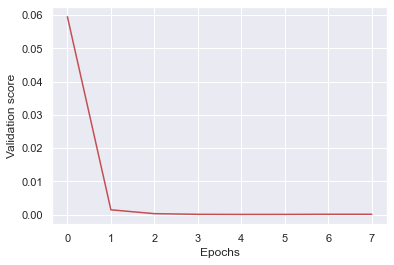

16.986628532409668


In [30]:
start_time = time.time()

early_stopping_monitor = EarlyStopping(patience=3)

n_neurons_layer = 500

# Create the model: model
model = Sequential()

# Add the first hidden layer
input_shape = (X.shape[1],)
model.add( Dense(n_neurons_layer, activation='relu', input_shape = input_shape) )

# Add the second hidden layer
model.add( Dense(n_neurons_layer, activation='relu') )

# Add the third hidden layer
model.add( Dense(n_neurons_layer, activation='relu') )

# Add the fourth hidden layer
model.add( Dense(n_neurons_layer, activation='relu') )

# Add the output layer
no_of_outputs = len(np.unique(y))
model.add( Dense( no_of_outputs , activation='softmax') )

# Compile the model
model.compile( optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Fit the model
# X -> X.values
model_training = model.fit(X.values, y, epochs=15, validation_split=0.2, callbacks=[early_stopping_monitor], verbose=False)

# Create the plot
plt.plot(model_training.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

elapsed_time = time.time() - start_time
print(elapsed_time)

In [31]:
%%time

# hasattr(tf_gradients_impl, "_IsBackpropagatable")
background = X.loc[X.index[np.random.choice(X.shape[0], 200, replace=False)]]

# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
e = shap.DeepExplainer(model, background.values)
shap_values = e.shap_values(background.values)

Wall time: 3.19 s


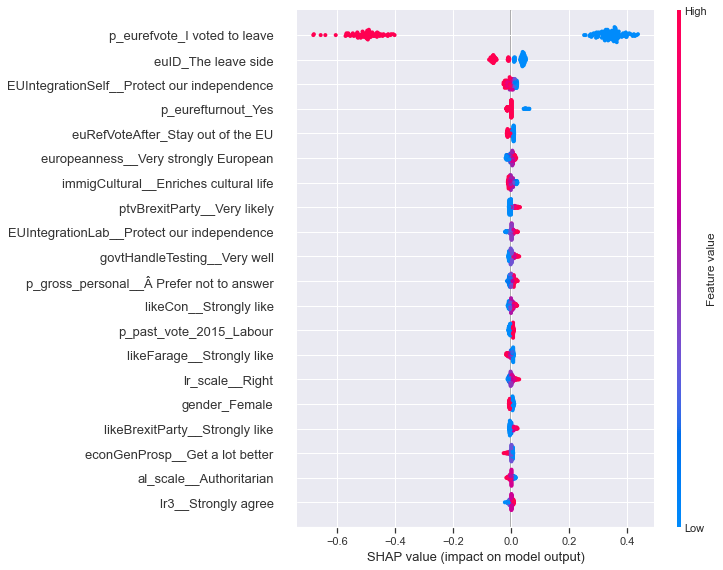

Wall time: 315 ms


In [32]:
%%time
shap.summary_plot(shap_values[0], background, plot_type='dot')

In [33]:
X.shape[1]

742

In [34]:
search(BES_reduced,"euRef")

p_eurefvote_I voted to leave         31468
p_eurefturnout_Yes                   31468
euRefVoteAfter_Stay out of the EU    31468
dtype: int64

In [35]:
BES_reduced.corrwith( BES_reduced['p_eurefvote_I voted to leave'] ).sort_values().head(10)

europeanness__Very strongly European    -0.505684
immigSelf__Allow many more              -0.494151
immigCultural__Enriches cultural life   -0.476114
immigEcon__Good for economy             -0.443282
likeLD__Strongly like                   -0.423664
likeLab__Strongly like                  -0.407686
ptvLD__Very likely                      -0.406763
ptvLab__Very likely                     -0.398804
likeGrn__Strongly like                  -0.382075
likeStarmer__Strongly like              -0.346852
dtype: float64

In [36]:
# this is the code from https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
from __future__ import print_function
import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.python.keras.utils.np_utils import to_categorical
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Epoch 1/12
469/469 [==============================] - 7s 11ms/step - loss: 2.2917 - accuracy: 0.1413 - val_loss: 2.2763 - val_accuracy: 0.2930
Epoch 2/12
469/469 [==============================] - 5s 10ms/step - loss: 2.2670 - accuracy: 0.2375 - val_loss: 2.2469 - val_accuracy: 0.4549
Epoch 3/12
469/469 [==============================] - 5s 10ms/step - loss: 2.2374 - accuracy: 0.3226 - val_loss: 2.2102 - val_accuracy: 0.5275
Epoch 4/12
469/469 [==============================] - 5s 10ms/step - loss: 2.1984 - accuracy: 0.3845 - val_loss: 2.1607 - val_accuracy: 0.5692
Epoch 5/12
469/469 [==============================] - 5s 10ms/step - loss: 2.1455 - accuracy: 0.4287 - val_loss: 2.0922 - val_accuracy: 0.6017
Epoch 6/12
469/469 [==============================] - 5s 10ms/step - loss: 2.0721 - accuracy: 0.4694 - val_loss: 1.9972 - val_accuracy: 0.6310
Epoch 7/12
469/469 [==============================] - 6s 12ms/step - 

In [37]:
# # (x_train, _), (x_test, _) = fashion_mnist.load_data()

# from tensorflow.python.keras._impl.keras.datasets.mnist import load_data
# (x_train, _), (x_test, _) = load_data()

# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.

# print (x_train.shape)
# print (x_test.shape)

In [38]:
# latent_dim = 64 

# class Autoencoder(Model):
#   def __init__(self, latent_dim):
#     super(Autoencoder, self).__init__()
#     self.latent_dim = latent_dim   
#     self.encoder = tf.keras.Sequential([
#       layers.Flatten(),
#       layers.Dense(latent_dim, activation='relu'),
#     ])
#     self.decoder = tf.keras.Sequential([
#       layers.Dense(784, activation='sigmoid'),
#       layers.Reshape((28, 28))
#     ])

#   def call(self, x):
#     encoded = self.encoder(x)
#     decoded = self.decoder(encoded)
#     return decoded

# autoencoder = Autoencoder(latent_dim)

# autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

(60000, 784)
(10000, 784)
Epoch 1/50
235/235 - 1s - loss: 0.6941 - val_loss: 0.6941
Epoch 2/50
235/235 - 1s - loss: 0.6940 - val_loss: 0.6939
Epoch 3/50
235/235 - 1s - loss: 0.6938 - val_loss: 0.6938
Epoch 4/50
235/235 - 1s - loss: 0.6937 - val_loss: 0.6936
Epoch 5/50
235/235 - 0s - loss: 0.6935 - val_loss: 0.6934
Epoch 6/50
235/235 - 1s - loss: 0.6933 - val_loss: 0.6933
Epoch 7/50
235/235 - 1s - loss: 0.6932 - val_loss: 0.6931
Epoch 8/50
235/235 - 1s - loss: 0.6930 - val_loss: 0.6930
Epoch 9/50
235/235 - 1s - loss: 0.6929 - val_loss: 0.6928
Epoch 10/50
235/235 - 1s - loss: 0.6927 - val_loss: 0.6927
Epoch 11/50
235/235 - 1s - loss: 0.6926 - val_loss: 0.6925
Epoch 12/50
235/235 - 1s - loss: 0.6924 - val_loss: 0.6924
Epoch 13/50
235/235 - 1s - loss: 0.6923 - val_loss: 0.6922
Epoch 14/50
235/235 - 1s - loss: 0.6921 - val_loss: 0.6921
Epoch 15/50
235/235 - 1s - loss: 0.6920 - val_loss: 0.6919
Epoch 16/50
235/235 - 1s - loss: 0.6919 - val_loss: 0.6918
Epoch 17/50
235/235 - 1s - loss: 0.6917

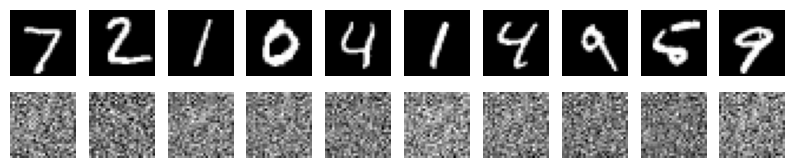

In [39]:


# Single fully-connected neural layer as encoder and decoder
use_regularizer = False
my_regularizer = None
my_epochs = 50
features_path = 'simple_autoe_features.pickle'
labels_path = 'simple_autoe_labels.pickle'

if use_regularizer:
    # add a sparsity constraint on the encoded representations
    # note use of 10e-5 leads to blurred results
    my_regularizer = regularizers.l1(10e-8)
    # and a larger number of epochs as the added regularization the model
    # is less likely to overfit and can be trained longer
    my_epochs = 100
    features_path = 'sparse_autoe_features.pickle'
    labels_path = 'sparse_autoe_labels.pickle'

# this is the size of our encoded representations
encoding_dim = 32   # 32 floats -> compression factor 24.5, assuming the input is 784 floats

# this is our input placeholder; 784 = 28 x 28
input_img = Input(shape=(784, ))

# "encoded" is the encoded representation of the inputs
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=my_regularizer)(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# Separate Encoder model

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# Separate Decoder model

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

# Train to reconstruct MNIST digits

# configure model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# prepare input data
(x_train, _), (x_test, y_test) = mnist.load_data()

# normalize all values between 0 and 1 and flatten the 28x28 images into vectors of size 784
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

# Train autoencoder for 50 epochs

autoencoder.fit(x_train, x_train, epochs=my_epochs, batch_size=256, shuffle=True, validation_data=(x_test, x_test),
                verbose=2)

# after 50/100 epochs the autoencoder seems to reach a stable train/test lost value

# Visualize the reconstructed encoded representations

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# save latent space features 32-d vector
pickle.dump(encoded_imgs, open(features_path, 'wb'))
pickle.dump(y_test, open(labels_path, 'wb'))

n = 10  # how many digits we will display
plt.figure(figsize=(10, 2), dpi=100)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

plt.show()

In [40]:
X_old = X.copy()

In [41]:
X=X/X.max()

In [42]:
low_var_columns = X.columns[X.var()<.05]
X.drop(low_var_columns,axis=1,inplace=True)

In [43]:
def run_autoencoder(encoding_dim=32,hidden_size=100,verbose=2):

    # Single fully-connected neural layer as encoder and decoder
    use_regularizer = True
    my_regularizer = None
    my_epochs = 50
    features_path = 'simple_autoe_features.pickle'
    labels_path = 'simple_autoe_labels.pickle'

    early_stopping_monitor = EarlyStopping(patience=3)

    if use_regularizer:
        # add a sparsity constraint on the encoded representations
        # note use of 10e-5 leads to blurred results
    #     my_regularizer = regularizers.l1(10e-8)
        # and a larger number of epochs as the added regularization the model
        # is less likely to overfit and can be trained longer
        my_epochs = 100
        features_path = 'sparse_autoe_features.pickle'
        labels_path = 'sparse_autoe_labels.pickle'

    # this is the size of our encoded representations
    # encoding_dim = encoding_dim   # 32 floats -> compression factor 24.5, assuming the input is 784 floats
    # hidden_size = hidden_size


    # this is our input placeholder; 784 = 28 x 28
    # input_img = Input(shape=(784, ))

    input_img = Input(shape=(X.shape[1], ))

    # "encoded" is the encoded representation of the inputs
    hidden_encoder = Dense(hidden_size, activation = 'relu',
                           activity_regularizer=regularizers.l1(10e-7) )(input_img)
    encoded = Dense(encoding_dim, activation='relu',
                    kernel_regularizer=regularizers.l2(10e-7))(hidden_encoder)
    # encoded = Dense(encoding_dim, activation='relu', activity_regularizer=my_regularizer)(input_img)


    # "decoded" is the lossy reconstruction of the input
    # decoded = Dense(X.shape[1], activation='sigmoid')(encoded)

    hidden_decoder = Dense(hidden_size, activation = 'relu',
                          kernel_regularizer=regularizers.l2(10e-7))(encoded)
    decoded = Dense(X.shape[1], activation='linear',
                          kernel_regularizer=regularizers.l2(10e-7))(hidden_decoder)
    # decoded = Dense(X.shape[1], activation='linear')(encoded)
    # decoded = Dense(X.shape[1], activation='softmax')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    # Separate Encoder model

    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)

    # Separate Decoder model

    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # hidden_layer_input = Input(shape=(hidden_size,))
    # retrieve the last layer of the autoencoder model
    ## changed to -2 after adding hidden layer!
    # decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    # decoder = Model(encoded_input, decoder_layer(hidden_layer_input))
    from tensorflow.python.keras.layers import InputLayer
    encoded_input_layer = InputLayer(input_shape=(encoding_dim,))
    # decoder = Model(encoded_input, decoder_layer(encoded_input))

    decoder = extract_layers(autoencoder, -2, -1, encoded_input_layer)

    # Train to reconstruct MNIST digits

    # configure model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer
    # autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    # autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    autoencoder.compile( optimizer = 'adam',
    #                loss = 'categorical_crossentropy',
    #                loss = 'categorical_crossentropy',
                   loss = 'mean_squared_error',     
                   metrics=['accuracy','mse'])


    # # prepare input data
    # (x_train, _), (x_test, y_test) = mnist.load_data()

    # # normalize all values between 0 and 1 and flatten the 28x28 images into vectors of size 784
    # x_train = x_train.astype('float32') / 255.
    # x_test = x_test.astype('float32') / 255.
    # x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    # x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    # print(x_train.shape)
    # print(x_test.shape)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)

    # Train autoencoder for 50 epochs

    autoencoder.fit(X_train.values, X_train.values, epochs=my_epochs, batch_size=256,
                    shuffle=True, validation_data=(X_test.values, X_test.values),
                    verbose=verbose, callbacks=[early_stopping_monitor])

    # after 50/100 epochs the autoencoder seems to reach a stable train/test lost value

    # Visualize the reconstructed encoded representations

    # encode and decode some digits
    # note that we take them from the *test* set
    encoded_imgs = encoder.predict(X_test.values)
    decoded_imgs = decoder.predict(encoded_imgs)

    # save latent space features 32-d vector
    pickle.dump(encoded_imgs, open(features_path, 'wb'))
    pickle.dump(y_test, open(labels_path, 'wb'))

    # n = 10  # how many digits we will display
    # plt.figure(figsize=(10, 2), dpi=100)
    # for i in range(n):
    #     # display original
    #     ax = plt.subplot(2, n, i + 1)
    #     plt.imshow(x_test[i].reshape(28, 28))
    #     plt.gray()
    #     ax.set_axis_off()

    #     # display reconstruction
    #     ax = plt.subplot(2, n, i + n + 1)
    #     plt.imshow(decoded_imgs[i].reshape(28, 28))
    #     plt.gray()
    #     ax.set_axis_off()

    # plt.show()
    
    return decoded_imgs,X_test,encoded_imgs,autoencoder

In [44]:
import warnings
warnings.filterwarnings('ignore')

for encoding_dim in [1,2,4,8,16,32]:
    for hidden_size in [50,100,200]:
        print("encoding_dim = "+str(encoding_dim),"hidden_size = "+str(hidden_size))
        decoded_imgs,X_test,encoded_imgs,autoencoder = run_autoencoder(encoding_dim=encoding_dim,hidden_size=hidden_size,verbose=0)

        X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)
    #     X_test_reconst["p_past_vote_2019_Conservative"].hist(bins=100)
        print("p_past_vote_2019_Conservative correlation =")
        print(X_test_reconst["p_past_vote_2019_Conservative"].corr(X_test["p_past_vote_2019_Conservative"]))
        print("mean correlation =")
        print(X_test_reconst.apply(lambda x: X_test_reconst[x.name].corr( X_test[x.name] ) ).mean())

encoding_dim = 1 hidden_size = 50
p_past_vote_2019_Conservative correlation =
0.8092663105682066
mean correlation =
0.25469132752848234
encoding_dim = 1 hidden_size = 100
p_past_vote_2019_Conservative correlation =
0.8113535222189492
mean correlation =
0.2548473009548986
encoding_dim = 1 hidden_size = 200
p_past_vote_2019_Conservative correlation =
-0.009314843980818771
mean correlation =
0.0008453878324286496
encoding_dim = 2 hidden_size = 50
p_past_vote_2019_Conservative correlation =
0.8354366930450181
mean correlation =
0.3299125589377546
encoding_dim = 2 hidden_size = 100
p_past_vote_2019_Conservative correlation =
0.8264910608716379
mean correlation =
0.3305304285193048
encoding_dim = 2 hidden_size = 200
p_past_vote_2019_Conservative correlation =
0.8332118270029174
mean correlation =
0.26071041059381567
encoding_dim = 4 hidden_size = 50
p_past_vote_2019_Conservative correlation =
0.8442166028518048
mean correlation =
0.41070131401573207
encoding_dim = 4 hidden_size = 100
p_past_

In [45]:
decoded_imgs,X_test,encoded_imgs,autoencoder = run_autoencoder(encoding_dim=1,hidden_size=100,verbose=0)
X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)

In [46]:
pd.Series(encoded_imgs.reshape(X_test.shape[0]),index=X_test.index)
# pd.Series(encoded_imgs,index=X_test.index)

id
66014     2.680523
78512     2.181242
102320    0.267146
44782     1.202553
100932    1.183017
            ...   
51434     3.176412
101213    0.558408
14449     3.813118
7930      0.710661
59978     0.000000
Length: 10385, dtype: float32

In [47]:
X_test_reconst.shape

(10385, 289)

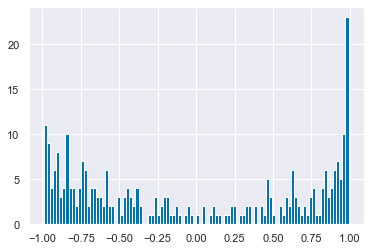

In [48]:
X_test_reconst.corrwith(pd.Series(encoded_imgs.reshape(X_test.shape[0]),index=X_test.index)).sort_values().hist(bins=100)

In [49]:
X_test_reconst.corrwith(pd.Series(encoded_imgs.reshape(X_test.shape[0]),index=X_test.index)).sort_values().head(50)

likeLD__Strongly like                                                                                           -0.988948
lr1__Strongly agree                                                                                             -0.981356
enviroGrowth__Protecting the environment should have priority                                                   -0.979702
likeGrn__Strongly like                                                                                          -0.979565
changeEconomyLab__Getting a lot better                                                                          -0.978279
ptvLD__Very likely                                                                                              -0.978141
likeStarmer__Strongly like                                                                                      -0.976797
lr4__Strongly agree                                                                                             -0.973771
likeLab__Strongly like  

In [50]:
X_test_reconst.corrwith(pd.Series(encoded_imgs.reshape(X_test.shape[0]),index=X_test.index)).sort_values().tail(50)

al1__Strongly agree                                                                         0.895041
p_religion_Yes - Church of England/Anglican/Episcopal                                       0.899293
benefitsNotDeserved__Strongly agree                                                         0.901032
govtHandouts__Strongly agree                                                                0.906797
al3__Strongly agree                                                                         0.910579
trustGov2_Government D                                                                      0.914197
trustMPs__A great deal of trust                                                             0.917992
conPriorities_nhs_Yes                                                                       0.918962
sector_Private sector firm of company Including, for example, limited companies and PLCs    0.924045
highRiskMedical_none_Yes                                                                   

In [51]:
X_test_reconst.apply(lambda x: X_test_reconst[x.name].corr( X_test[x.name] ) ).sort_values().tail(50)


benefitsNotDeserved__Strongly agree            0.497512
lr1__Strongly agree                            0.498810
ptvLD__Very likely                             0.504503
privateEnterprise__Strongly agree              0.513829
al2__Strongly agree                            0.519501
immigEcon__Good for economy                    0.526800
p_work_stat_Retired                            0.528736
bestOnMII_Labour                               0.529451
ptvBrexitParty__Very likely                    0.529799
p_past_vote_2005_Labour                        0.530907
workingStatus_Retired                          0.532552
likeStarmer__Strongly like                     0.533924
handleCoronaLab__Very well                     0.536511
govtHandleTesting__Very well                   0.539749
ptvGrn__Very likely                            0.545331
europeanness__Very strongly European           0.554206
changeEconomyLab__Getting a lot better         0.555487
al1__Strongly agree                            0

In [52]:
autoencoder.summary()

Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 289)]             0         
_________________________________________________________________
dense_88 (Dense)             (None, 100)               29000     
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 101       
_________________________________________________________________
dense_90 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_91 (Dense)             (None, 289)               29189     
Total params: 58,490
Trainable params: 58,490
Non-trainable params: 0
_________________________________________________________________


In [53]:
autoencoder.summary()

Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 289)]             0         
_________________________________________________________________
dense_88 (Dense)             (None, 100)               29000     
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 101       
_________________________________________________________________
dense_90 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_91 (Dense)             (None, 289)               29189     
Total params: 58,490
Trainable params: 58,490
Non-trainable params: 0
_________________________________________________________________


In [54]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


In [55]:
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_15 (Dense)             (None, 784)               25872     
Total params: 25,872
Trainable params: 25,872
Non-trainable params: 0
_________________________________________________________________


In [56]:
autoencoder.layers[-1]

In [57]:
encoded_input

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'input_2')>

In [58]:
# # Model(input_img, autoencoder.layers[])
# Model(encoded_input, autoencoder.layers[-1](encoded_input))

In [59]:
# # create a placeholder for an encoded (32-dimensional) input
# encoded_input = Input(shape=(encoding_dim,))
# # retrieve the last layer of the autoencoder model
# ## changed to -2 after adding hidden layer!
# decoder_layer = autoencoder.layers[-1]
# # create the decoder model
# decoder = Model(encoded_input, decoder_layer(encoded_input))

In [60]:
# encoding_dim = 32
# Epoch 2/50
#  - 2s - loss: 5935.9533 - acc: 0.3057 - val_loss: 5822.0374 - val_acc: 0.5679
# Epoch 50/50
#  - 2s - loss: 5680.6994 - acc: 0.8580 - val_loss: 5683.9633 - val_acc: 0.8727

# encoding_dim = 16
# Epoch 2/50
#  - 2s - loss: 5978.8631 - acc: 0.8325 - val_loss: 5866.3392 - val_acc: 0.8639
# Epoch 50/50
#  - 3s - loss: 5694.4223 - acc: 0.8617 - val_loss: 5697.4094 - val_acc: 0.8703

# encoding_dim = 8
# Epoch 2/50
#  - 2s - loss: 5970.0431 - acc: 0.8586 - val_loss: 5835.3781 - val_acc: 0.8639
# Epoch 50/50
#  - 2s - loss: 5715.6143 - acc: 0.8595 - val_loss: 5718.3449 - val_acc: 0.8642

# encoding_dim = 1
# Epoch 2/50
#  - 2s - loss: 6096.5372 - acc: 0.0000e+00 - val_loss: 6056.0097 - val_acc: 0.0000e+00
# Epoch 38/50
#  - 2s - loss: 5753.8536 - acc: 0.0416 - val_loss: 5756.7104 - val_acc: 0.0403

# encoding_dim = 2
# Epoch 2/50
#  - 2s - loss: 6086.2950 - acc: 0.0000e+00 - val_loss: 6052.0046 - val_acc: 0.0000e+00
# Epoch 41/50
#  - 2s - loss: 5729.3915 - acc: 0.8586 - val_loss: 5731.9737 - val_acc: 0.8639

## WTF!
# encoding_dim = 3
# Epoch 2/50
#  - 2s - loss: 6062.5483 - acc: 0.0074 - val_loss: 6017.2380 - val_acc: 0.0075
# Epoch 38/50
#  - 3s - loss: 5735.6843 - acc: 0.0442 - val_loss: 5738.1730 - val_acc: 0.0402

# encoding_dim = 4
# Epoch 2/50
#  - 2s - loss: 6040.1189 - acc: 4.7432e-05 - val_loss: 5968.3275 - val_acc: 0.0000e+00
# Epoch 50/50
#  - 2s - loss: 5723.7691 - acc: 0.8586 - val_loss: 5726.4317 - val_acc: 0.8639                   

In [61]:
# encoding_dim = 4
# hidden_size = 0

# Epoch 2/50
#  - 1s - loss: 2.0178 - acc: 0.8586 - val_loss: 1.8578 - val_acc: 0.8639
# Epoch 50/50
#  - 2s - loss: 0.3624 - acc: 0.9903 - val_loss: 0.3628 - val_acc: 0.9922

In [62]:
# encoded_imgs = encoder.predict(X_test.values)
# decoded_imgs = decoder.predict(encoded_imgs)

# # save latent space features 32-d vector
# pickle.dump(encoded_imgs, open(features_path, 'wb'))
# pickle.dump(y_test, open(labels_path, 'wb'))


In [63]:
encoded_imgs.shape

(10385, 1)

In [64]:
# # %%time

# # hasattr(tf_gradients_impl, "_IsBackpropagatable")
# background = X.loc[X.index[np.random.choice(X.shape[0], 200, replace=False)]]

# # e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
# e = shap.DeepExplainer(model, background.values)
# shap_values = e.shap_values(background.values)

In [65]:
decoder_layer.input_shape

(None, 32)

In [66]:
encoded_imgs.shape

(10385, 1)

In [67]:
encoded_imgs.shape

(10385, 1)

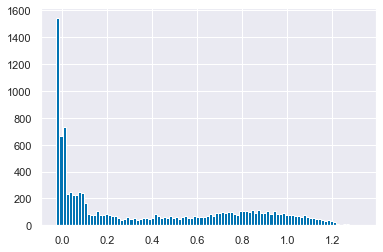

In [68]:
X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)
X_test_reconst["p_past_vote_2019_Conservative"].hist(bins=100)

In [69]:
X_test_reconst["p_past_vote_2019_Conservative"].corr(X_test["p_past_vote_2019_Conservative"])

0.8102326791364531

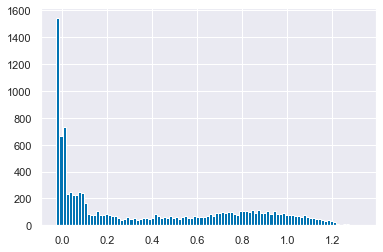

In [70]:
X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)
X_test_reconst["p_past_vote_2019_Conservative"].hist(bins=100)

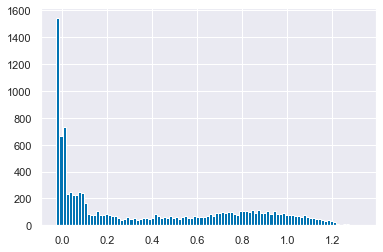

In [71]:
X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)
X_test_reconst["p_past_vote_2019_Conservative"].hist(bins=100)

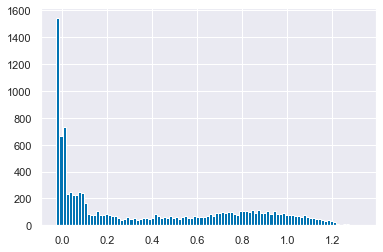

In [72]:
X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)
X_test_reconst["p_past_vote_2019_Conservative"].hist(bins=100)

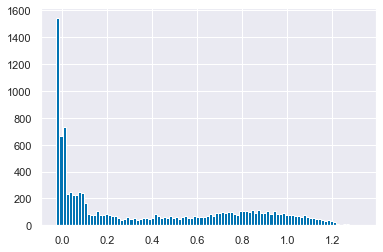

In [73]:
X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)
X_test_reconst["p_past_vote_2019_Conservative"].hist(bins=100)

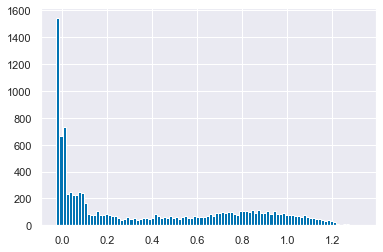

In [74]:
X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)
X_test_reconst["p_past_vote_2019_Conservative"].hist(bins=100)

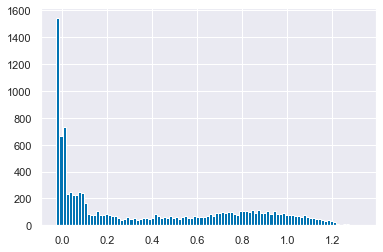

In [75]:
X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)
X_test_reconst["p_past_vote_2019_Conservative"].hist(bins=100)

In [76]:
decoded_imgs.shape

(10385, 289)

In [77]:
X_test["p_past_vote_2019_Conservative"].value_counts()

0.0    6541
1.0    3844
Name: p_past_vote_2019_Conservative, dtype: int64

In [78]:
X_test_reconst["p_past_vote_2019_Conservative"].corr(X_test["p_past_vote_2019_Conservative"])

0.8102326791364531

In [79]:
X_test["p_past_vote_2019_Conservative"]

id
66014     1.0
78512     1.0
102320    0.0
44782     0.0
100932    0.0
         ... 
51434     1.0
101213    0.0
14449     1.0
7930      0.0
59978     0.0
Name: p_past_vote_2019_Conservative, Length: 10385, dtype: float32

In [80]:
X_test_reconst["p_past_vote_2019_Conservative"]

id
66014     0.776489
78512     0.530568
102320   -0.001740
44782     0.065856
100932    0.062531
            ...   
51434     0.987130
101213   -0.016893
14449     1.258140
7930     -0.017876
59978     0.012158
Name: p_past_vote_2019_Conservative, Length: 10385, dtype: float32

In [81]:
X_test["p_past_vote_2019_Conservative"].mean()

0.37014925

In [82]:
(X_test_reconst-X_test).applymap(lambda x: x**2).mean().sort_values()

likeCon__Strongly like                                                                      0.036620
privateEnterprise__Strongly agree                                                           0.040506
trustWestminster__Just about always                                                         0.041840
likeJohnson__Strongly like                                                                  0.042866
cvEconCon__Save the economy even if it increases infections                                 0.043108
                                                                                              ...   
partnerEducation_GCE A level or Higher Certificate                                          0.237871
highRiskMedical_none_Yes                                                                    0.239978
sector_Private sector firm of company Including, for example, limited companies and PLCs    0.241527
coronaMeasures2_5_Yes                                                                      

In [83]:
X_test_reconst["p_past_vote_2019_Conservative"].sum(),X_test["p_past_vote_2019_Conservative"].sum()

(4014.4805, 3844.0)

In [84]:
X_test_reconst["p_past_vote_2019_Conservative"].sum(),X_test["p_past_vote_2019_Conservative"].sum()

(4014.4805, 3844.0)

In [85]:
encoded_imgs

array([[2.6805234 ],
       [2.1812422 ],
       [0.26714563],
       ...,
       [3.8131185 ],
       [0.7106612 ],
       [0.        ]], dtype=float32)

In [86]:
X.max()

turnoutUKGeneral__Very likely that I will vote    1.0
partyIdStrength__Not very strong                  1.0
polAttention__Pay a great deal of attention       1.0
likeJohnson__Strongly like                        1.0
likeStarmer__Strongly like                        1.0
                                                 ... 
responsibleEconC_2_Yes                            1.0
responsibleEconC_1_Yes                            1.0
coronaMeasures_2_Yes                              1.0
coronaMeasures_1_Yes                              1.0
coronaMeasures_4_Yes                              1.0
Length: 289, dtype: float32

In [87]:
prep = BES_Panel.select_dtypes('category')
prep = prep.copy()#[temp.columns[0:100]].copy()
prep.dropna(axis=1,inplace=True)

y = BES_Panel['p_eurefvote']

In [88]:
# search(BES_Panel,"eurefvote")

In [89]:

# y = to_categorical(y)

In [90]:
# prepare target
# def prepare_targets(y_train, y_test):
#     le = LabelEncoder()
#     le.fit(y_train)
#     y_train_enc = le.transform(y_train)
#     y_test_enc = le.transform(y_test)
#     return y_train_enc, y_test_enc


enc = OrdinalEncoder()

X = enc.fit_transform(prep)
X = pd.DataFrame(X,columns = prep.columns,index = prep.index)

In [91]:
# X = prep

In [92]:
# no_hidden_layers=2
# x = pow(X.shape[1]/encoding_dim,1/ (no_hidden_layers+1) )
# [encoding_dim]+[int(encoding_dim*pow(x,y)) for y in range(1,no_hidden_layers+1)]

In [93]:
# all layers
def get_kernel_regularizer(orthogonality_constraint,dimension,axis,weight=10e-7,weightage=1.0):
    if orthogonality_constraint:
        return WeightsOrthogonalityConstraint(dimension, weightage=weightage, axis=axis)
    else:
        return regularizers.l2(weight)

# just encoding layer (all of them or just final? Just final surely?)
def get_activity_regularizer(uncorrelated_features,encoding_dim, weightage = 1.):
    if uncorrelated_features:
        return UncorrelatedFeaturesConstraint(encoding_dim, weightage = 1.)
    else:
        return None

# all layers: kernel_constraint=get_kernel_constraint(unit_norm, axis)
def get_kernel_constraint(unit_norm, axis):
    if unit_norm:
        return UnitNorm(axis=axis)
    else:
        return None    

def run_autoencoder(encoding_dim=32,hidden_size=100,verbose=2,
                    loss='mean_squared_error',metrics=['accuracy','mse'],optimizer='adam',
                    penultimate_act = 'relu',ultimate_act = 'linear',max_epochs=100,
                    no_hidden_layers=1,
                    tied_layers = False, orthogonality_constraint = False,uncorrelated_features=False,unit_norm=False,
                    regularizer_weight=10e-7):

    # get rough intermediate sizes for hidden layers
    x = pow(X.shape[1]/encoding_dim,1/ (no_hidden_layers+1) )
    if no_hidden_layers!=1:
        hidden_layer_size = [int(encoding_dim*pow(x,y)) for y in range(1,no_hidden_layers+1)]
    else:
        hidden_layer_size = [hidden_size]
    
     
    
    # Single fully-connected neural layer as encoder and decoder
    use_regularizer = True
#     my_regularizer = None
#     my_epochs = 50
    features_path = 'simple_autoe_features.pickle'
    labels_path = 'simple_autoe_labels.pickle'

    early_stopping_monitor = EarlyStopping(patience=3)

    if use_regularizer:
        # add a sparsity constraint on the encoded representations
        # note use of 10e-5 leads to blurred results
    #     my_regularizer = regularizers.l1(10e-8)
        # and a larger number of epochs as the added regularization the model
        # is less likely to overfit and can be trained longer
#         my_epochs = 100
        features_path = 'sparse_autoe_features.pickle'
        labels_path = 'sparse_autoe_labels.pickle'

    # this is the size of our encoded representations
    # encoding_dim = encoding_dim   # 32 floats -> compression factor 24.5, assuming the input is 784 floats
    # hidden_size = hidden_size

# encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias=True,
#                 kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)) 
# decoder = Dense(input_dim, activation="linear", use_bias = True,
#                 kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=1))    


    

    # this is our input placeholder; 784 = 28 x 28
    # input_img = Input(shape=(784, ))

    input_img = Input(shape=(X.shape[1], ))

    encoder_list = []
    
    # "encoded" is the encoded representation of the inputs
    hidden_encoder = input_img
    for hidden_layer_number in range(no_hidden_layers-1,-1,-1):       
        
        d = Dense(hidden_layer_size[hidden_layer_number], activation = penultimate_act,
                          kernel_regularizer=get_kernel_regularizer(orthogonality_constraint,
                                                                    hidden_layer_size[hidden_layer_number],
                                                                    axis=0, weight=regularizer_weight),
                          kernel_constraint=get_kernel_constraint(unit_norm, axis=0)
                 )
        
        hidden_encoder = d(hidden_encoder)
        encoder_list.append(d)
    
    d = Dense(encoding_dim, activation=penultimate_act,
                          kernel_regularizer=get_kernel_regularizer(orthogonality_constraint,
                                                encoding_dim,
                                                axis=0, weight=regularizer_weight),
                          activity_regularizer= get_activity_regularizer(uncorrelated_features,encoding_dim, weightage = 1.),
                          kernel_constraint=get_kernel_constraint(unit_norm, axis=0)
             )
    
    encoded = d(hidden_encoder)
    encoder_list.append(d)
    # encoded = Dense(encoding_dim, activation='relu', activity_regularizer=my_regularizer)(input_img)


    # "decoded" is the lossy reconstruction of the input
    # decoded = Dense(X.shape[1], activation='sigmoid')(encoded)
    
    
#     decoder = DenseTied(input_dim, activation="linear", tied_to=encoder, use_bias = True)   
    
    hidden_decoder = encoded
    for hidden_layer_number in range(0,no_hidden_layers):
        if tied_layers:
            hidden_decoder = DenseTied(hidden_layer_size[hidden_layer_number], activation = penultimate_act,
                                      tied_to=encoder_list[no_hidden_layers-hidden_layer_number],
                                      kernel_regularizer=get_kernel_regularizer(orthogonality_constraint,
                                                                    ([encoding_dim]+hidden_layer_size)[hidden_layer_number],
                                                                    axis=1, weight=regularizer_weight),  
                                      kernel_constraint=get_kernel_constraint(unit_norm, axis=1),
                                      )(hidden_decoder)
            
        else:
            hidden_decoder = Dense(hidden_layer_size[hidden_layer_number], activation = penultimate_act,
                                      kernel_regularizer=get_kernel_regularizer(orthogonality_constraint,
                                                ([encoding_dim]+hidden_layer_size)[hidden_layer_number],
                                                 axis=1, weight=regularizer_weight),   
                                      kernel_constraint=get_kernel_constraint(unit_norm, axis=1)
                                      )(hidden_decoder)
            
    if tied_layers:
        decoded = DenseTied(X.shape[1], activation=ultimate_act,
                          tied_to=encoder_list[0],
                          kernel_regularizer=get_kernel_regularizer(orthogonality_constraint,
                                    ([encoding_dim]+hidden_layer_size)[no_hidden_layers],
                                     axis=1, weight=regularizer_weight),   
                                     kernel_constraint=get_kernel_constraint(unit_norm, axis=1)
                           )(hidden_decoder)

    else:            
        decoded = Dense(X.shape[1], activation=ultimate_act,
                          kernel_regularizer=get_kernel_regularizer(orthogonality_constraint,
                                    ([encoding_dim]+hidden_layer_size)[no_hidden_layers],
                                     axis=1, weight=regularizer_weight),  
                          kernel_constraint=get_kernel_constraint(unit_norm, axis=1)
                       )(hidden_decoder)
    # decoded = Dense(X.shape[1], activation='linear')(encoded)
    # decoded = Dense(X.shape[1], activation='softmax')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    # Separate Encoder model

    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)

    # Separate Decoder model

    # create a placeholder for an encoded (32-dimensional) input
#     encoded_input = Input(shape=(encoding_dim,))
    # hidden_layer_input = Input(shape=(hidden_size,))
    # retrieve the last layer of the autoencoder model
    ## changed to -2 after adding hidden layer!
    # decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    # decoder = Model(encoded_input, decoder_layer(hidden_layer_input))
    encoded_input_layer = InputLayer(input_shape=(encoding_dim,))
    # decoder = Model(encoded_input, decoder_layer(encoded_input))

    decoder = extract_layers(autoencoder, -1-no_hidden_layers, -1, encoded_input_layer)

    # Train to reconstruct MNIST digits

    # configure model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer
    # autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    # autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    autoencoder.compile( optimizer = optimizer,
    #                loss = 'categorical_crossentropy',
    #                loss = 'categorical_crossentropy',
                   loss = loss,     
                   metrics=metrics)


    # # prepare input data
    # (x_train, _), (x_test, y_test) = mnist.load_data()

    # # normalize all values between 0 and 1 and flatten the 28x28 images into vectors of size 784
    # x_train = x_train.astype('float32') / 255.
    # x_test = x_test.astype('float32') / 255.
    # x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    # x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    # print(x_train.shape)
    # print(x_test.shape)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)

    # Train autoencoder for 50 epochs

    if isinstance(X_test, pd.DataFrame):
        X_test_values = X_test.values
        X_train_values = X_train.values
    else:
        X_test_values = X_test
        X_train_values = X_train
    
    autoencoder.fit(X_train_values, X_train_values, epochs=max_epochs, batch_size=512,
                    shuffle=True, validation_data=(X_test_values, X_test_values),
                    verbose=verbose, callbacks=[early_stopping_monitor])

    # after 50/100 epochs the autoencoder seems to reach a stable train/test lost value

    # Visualize the reconstructed encoded representations

    # encode and decode some digits
    # note that we take them from the *test* set
    encoded_imgs = encoder.predict(X_test_values)
    decoded_imgs = decoder.predict(encoded_imgs)

    # save latent space features 32-d vector
    pickle.dump(encoded_imgs, open(features_path, 'wb'))
    pickle.dump(y_test, open(labels_path, 'wb'))

    # n = 10  # how many digits we will display
    # plt.figure(figsize=(10, 2), dpi=100)
    # for i in range(n):
    #     # display original
    #     ax = plt.subplot(2, n, i + 1)
    #     plt.imshow(x_test[i].reshape(28, 28))
    #     plt.gray()
    #     ax.set_axis_off()

    #     # display reconstruction
    #     ax = plt.subplot(2, n, i + n + 1)
    #     plt.imshow(decoded_imgs[i].reshape(28, 28))
    #     plt.gray()
    #     ax.set_axis_off()kernel_constrain

    # plt.show()
    
    return decoded_imgs,X_test,encoded_imgs,autoencoder,encoder,decoder

In [94]:
## turn all columns into something like cateogory


## dummy all columns, special option for nans
# dummy_na


## could do sparse output

In [95]:
prep.shape,BES_Panel.shape

((31468, 162), (31468, 463))

In [96]:
prep2 = BES_Panel.copy()
prep2["jobzone"] = prep2["jobzone"].astype('category')
prep2["country"] = prep2["country"].replace({1.0:"England",2.0:"Scotland",3.0:"Wales"}).astype('category')

In [97]:
prep2 = pd.get_dummies(prep2.select_dtypes('category'), dummy_na=True)
prep2_var = prep2.var()
prep2 = prep2[prep2_var[prep2_var>.005].index]

In [98]:
prep3 = BES_Panel.copy()
prep3 = prep3[search(BES_Panel,"p_").index]
prep3 = pd.get_dummies(prep3.select_dtypes('category'), dummy_na=True)

In [99]:
# prep2_var.shape[prep2_var<.01]

# 2202/2540 /5105


In [100]:
# BES_Panel.apply(lambda x: x.dtype.name).value_counts()

In [101]:
# BES_Panel.select_dtypes('number')

In [102]:
prep = BES_Panel.select_dtypes('category')
prep = prep.copy()#[temp.columns[0:100]].copy()
prep.dropna(axis=1,inplace=True)

y = BES_Panel['p_eurefvote']

In [103]:
# prepare target
# def prepare_targets(y_train, y_test):
#     le = LabelEncoder()
#     le.fit(y_train)
#     y_train_enc = le.transform(y_train)
#     y_test_enc = le.transform(y_test)
#     return y_train_enc, y_test_enc
enc = OneHotEncoder(sparse=False)

X = enc.fit_transform(prep)
# X = pd.DataFrame(X,columns = prep.columns,index = prep.index)

In [104]:
# low_var_columns = X.columns[X.var()<.05]
not_low_var_columns = pd.DataFrame(X).columns[pd.DataFrame(X).var()>.005]
X = X[:,not_low_var_columns]
# X.drop(low_var_columns,axis=1,inplace=True)
X.shape

(31468, 1214)

In [105]:
X = prep3

In [106]:
# hidden_layer_size

In [107]:
# X.max()

In [108]:
# low_var_columns
# X
# if tied_layers:
#     print(1)

In [109]:
# not_low_var_columns
import warnings
warnings.filterwarnings('ignore')

In [110]:
losses = pd.DataFrame(columns = ['encoding_dim','hidden_size','num_epochs',
                                 'val_loss', 'val_acc', 'val_mean_squared_error', 'val_binary_accuracy',
                                 'val_binary_crossentropy', 'val_kullback_leibler_divergence', 'loss', 'acc',
                                 'mean_squared_error', 'binary_accuracy', 'binary_crossentropy', 'kullback_leibler_divergence',
                                 'mean_correlation'])
count = 0

In [111]:
losses = pd.read_csv("losses.csv")
losses.drop("Unnamed: 0",axis=1,inplace=True)
count = losses.index[-1]+1

In [112]:
## add noise, store old X in X_old

X_old = X.copy()

temp = pd.DataFrame(X).astype(bool)

rng = np.random.default_rng()
e = pd.DataFrame(rng.integers(0, 2, size=temp.shape) ).astype(bool)
e = np.random.uniform(0.0, 1.0, size=temp.shape )>.999

temp2 = np.where(e,(~temp).astype('int'),temp.astype('int'))
temp2 = pd.DataFrame(temp2,columns=temp.columns)
temp.apply(lambda x: pd.DataFrame(temp2)[x.name].corr( temp[x.name] ) )

X = temp2

In [113]:
# e.sum()/(e.shape[0]*e.shape[1])


In [114]:
# Epoch 161/200
# 42/42 - 0s - loss: 0.1313 - accuracy: 0.0096 - mse: 0.0353 - binary_accuracy: 0.9552 - binary_crossentropy: 0.1290 - kullback_leibler_divergence: 29.7100 - matthews_correlation: 0.7575 - val_loss: 0.1318 - val_accuracy: 0.0114 - val_mse: 0.0355 - val_binary_accuracy: 0.9550 - val_binary_crossentropy: 0.1295 - val_kullback_leibler_divergence: 30.0128 - val_matthews_correlation: 0.7556

In [115]:
losses2 = pd.DataFrame(columns = ['encoding_dim','hidden_size','num_epochs',
                                 'val_loss', 'val_acc', 'val_mean_squared_error', 'val_binary_accuracy',
                                 'val_binary_crossentropy', 'val_kullback_leibler_divergence','val_matthews_correlation' ,'loss', 'acc',
                                 'mean_squared_error', 'binary_accuracy', 'binary_crossentropy', 'kullback_leibler_divergence',
                                 'mean_correlation'])
count = 0

In [116]:


# encoding_dim=params['encoding_dim'],
# hidden_size=params['hidden_size'],
# no_hidden_layers=params['no_hidden_layers'],
# tied_layers=params['tied_layers'],
# # orthogonality_constraint=params['orthogonality_constraint'],
# uncorrelated_features=params['uncorrelated_features'],
# unit_norm=params['unit_norm'],
# regularizer_weight=params['regularizer_weight'],
# # optimizer=params['optimizer'],

from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

# define the space of hyperparameters to search
search_space = list()
# search_space.append(Real(1e-6, 1.0, 'log-uniform', name='lr'))
# search_space.append(Categorical(['linear', 'poly', 'rbf', 'sigmoid'], name='optimizer'))
# search_space.append(Real(10e-8, 10e-4, 'log-uniform', name='regularizer_weight'))
search_space.append(Integer(0, 1, name='unit_norm'))
search_space.append(Integer(0, 1, name='uncorrelated_features'))
search_space.append(Integer(0, 1, name='tied_layers'))
# search_space.append(Integer(0, 5, name='no_hidden_layers'))
# search_space.append(Integer(50, 200, name='hidden_size'))
# search_space.append(Integer(2, 100, name='encoding_dim'))


# search_space.append(Integer(0, 1, name='degree'))
# search_space.append(Real(10e-8, 10e-4, 'log-uniform', name='gamma'))

In [117]:
@use_named_args(search_space)
def evaluate_model(**params):
    ultimate_act='sigmoid'
    loss = 'binary_crossentropy'
        
    metrics = ['accuracy',
                'mse',
                'binary_accuracy',
                'binary_crossentropy',
                'kullback_leibler_divergence',
                matthews_correlation,
                ]
    verbose = 0
    max_epochs = 200
    
    shuffle=True
    batch_size=512
#     lr = .003
#     lr = params['lr']
    
#     batch_size=params['batch_size']
#     shuffle = params['shuffle']
#     orthogonality_constraint = False

#     encoding_dim=params['encoding_dim']
#     hidden_size=params['hidden_size']
#     no_hidden_layers=params['no_hidden_layers']
    tied_layers=params['tied_layers']
    orthogonality_constraint=False
    uncorrelated_features=params['uncorrelated_features']
    unit_norm=params['unit_norm']
#     regularizer_weight=params['regularizer_weight']
    print(tied_layers,uncorrelated_features,unit_norm)
    lr = .003
    encoding_dim = 13
    hidden_size = 100
    no_hidden_layers = 2
    regularizer_weight = 10e-6
    
    optimizer = tf.keras.optimizers.Adamax(lr=lr)
    
    decoded_imgs,X_test,encoded_imgs,autoencoder,encoder,decoder = run_autoencoder(encoding_dim=encoding_dim,
                                                                                   hidden_size=hidden_size,
                                                                                   verbose=verbose,
                                                                                   loss=loss,
                                                                                   ultimate_act=ultimate_act,
                                                                                   metrics=metrics,
                                                                                   max_epochs=max_epochs,
                                                                                   no_hidden_layers=no_hidden_layers,
                                                                                   tied_layers=tied_layers,
                                                                                   orthogonality_constraint=orthogonality_constraint,
                                                                                   uncorrelated_features=uncorrelated_features,
                                                                                   unit_norm=unit_norm,
                                                                                   regularizer_weight=regularizer_weight,
                                                                                   optimizer=optimizer,
                                                                                  )
    X_test = pd.DataFrame(X_test)
    X_test_reconst = pd.DataFrame(decoded_imgs)
    X_test_reconst.columns = X_test.columns
    X_test_reconst.index = X_test.index
    mean_correlation  = X_test_reconst.apply(lambda x: X_test_reconst[x.name].corr( X_test[x.name] ) ).mean()        

#         X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)
#         X_test_reconst["p_past_vote_2019_Conservative"].hist(bins=100)
#         print("p_past_vote_2019_Conservative correlation =")
#         print(X_test_reconst["p_past_vote_2019_Conservative"].corr(X_test["p_past_vote_2019_Conservative"]))
    print("mean correlation =")
    print(mean_correlation)
    elapsed_time = time.time() - start_time
    print("elapsed_time = ",elapsed_time)
    return autoencoder.history.history['loss'][-1]

In [ ]:
result = gp_minimize(evaluate_model, search_space, n_jobs=-1)
# summarizing finding:
print('Best Accuracy: %.3f' % (result.fun))
print('Best Parameters: %s' % (result.x))

1 0 1
mean correlation =
0.13022591197509034
elapsed_time =  689.7495942115784
1 1 1
mean correlation =
0.13535496994640941
elapsed_time =  781.4488613605499
0 0 0
mean correlation =
0.48989974499061323
elapsed_time =  839.6409268379211
1 0 0
mean correlation =
0.1488809463205085
elapsed_time =  893.8228867053986
0 1 1
mean correlation =
0.39725649045845063
elapsed_time =  956.2579460144043
0 0 0


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Best Accuracy: 0.997
# Best Parameters: [0.1812827106334912, 1e-07, 0, 1, 0, 0, 50, 100]
lr=.18, regularizer_weight=1e-07, unit_norm=0,uncorrelated_features=1,tied_layers=0,no_hidden_layers=0,hidden_size=50,encoding_dim=100


search_space.append(Real(1e-6, 1.0, 'log-uniform', name='lr'))
# search_space.append(Categorical(['linear', 'poly', 'rbf', 'sigmoid'], name='optimizer'))
search_space.append(Real(10e-8, 10e-4, 'log-uniform', name='regularizer_weight'))
search_space.append(Integer(0, 1, name='unit_norm'))
search_space.append(Integer(0, 1, name='uncorrelated_features'))
search_space.append(Integer(0, 1, name='tied_layers'))
search_space.append(Integer(0, 5, name='no_hidden_layers'))
search_space.append(Integer(50, 200, name='hidden_size'))
search_space.append(Integer(2, 100, name='encoding_dim'))









In [ ]:
description="regularizer_weight=10e-7 argument fixed"

hidden_size=100

# originally True
tied_layers=False
uncorrelated_features=True  ### this one broke with new code! ### FIXED

orthogonality_constraint=False ### broken
unit_norm=False

regularizer_weight=10e-6
# test this again
# try l1 regularizer?
no_hidden_layers=2
shuffle=True
batch_size=512
lr = .003

# bit_flip = .999
loss = 'binary_crossentropy'
# loss = dice_loss
# loss = balanced_cross_entropy
metrics = ['accuracy',
            'mse',
            'binary_accuracy',
            'binary_crossentropy',
            'kullback_leibler_divergence',
            matthews_correlation,
            ]


for encoding_dim in [13]:
    
    for regularizer_weight in [10e-6]: #,10e-7,10e-8
        optimizer = tf.keras.optimizers.Adamax(lr=lr)    
        # , beta_1=0.9, beta_2=0.999, epsilon=1e-07
        for no_hidden_layers in [1]:
        #[ [1,0,1,0],[1,1,1,0],[1,0,1,1],[1,1,1,1], ]:
        
#             (tied_layers,orthogonality_constraint,uncorrelated_features,unit_norm) = (bool(x) for x in combo)   
#         for regularizer_weight in [10e-8]:

#             description = str("learning_rate="+str(lr))
            description = "full dataset with hidden layers="+str(no_hidden_layers)
            start_time = time.time()
            print("encoding_dim = "+str(encoding_dim),"hidden_size = "+str(hidden_size),"no_hidden_layers = ",str(no_hidden_layers))
            
            decoded_imgs,X_test,encoded_imgs,autoencoder,encoder,decoder = run_autoencoder(encoding_dim=encoding_dim,
                                                                                           hidden_size=hidden_size,
                                                                                           verbose=2,
                                                                                           loss=loss,
                                                                                           ultimate_act='sigmoid',
                                                                                           metrics=metrics,
                                                                                          max_epochs=200,
                                                                                          no_hidden_layers=no_hidden_layers,
                                                                                          tied_layers=tied_layers,
                                                                                          orthogonality_constraint=orthogonality_constraint,
                                                                                          uncorrelated_features=uncorrelated_features,
                                                                                          unit_norm=unit_norm,
                                                                                          regularizer_weight=regularizer_weight,
                                                                                          optimizer=optimizer,
                                                                                          )

            X_test = pd.DataFrame(X_test)

            X_test_reconst = pd.DataFrame(decoded_imgs)
            X_test_reconst.columns = X_test.columns
            X_test_reconst.index = X_test.index
            mean_correlation  = X_test_reconst.apply(lambda x: X_test_reconst[x.name].corr( X_test[x.name] ) ).mean()        

    #         X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)
    #         X_test_reconst["p_past_vote_2019_Conservative"].hist(bins=100)
    #         print("p_past_vote_2019_Conservative correlation =")
    #         print(X_test_reconst["p_past_vote_2019_Conservative"].corr(X_test["p_past_vote_2019_Conservative"]))
            print("mean correlation =")
            print(mean_correlation)
            elapsed_time = time.time() - start_time
            print("elapsed_time = ",elapsed_time)
            losses2.loc[count] = [encoding_dim,hidden_size]+[autoencoder.history.epoch[-1]]+[x[-1] for x in autoencoder.history.history.values()]+[mean_correlation]+[no_hidden_layers]+[elapsed_time]+[description]
            count=count+1        

In [ ]:
# uncorrelated_features=True
# tied_layers=True
# Epoch 200/200
# 42/42 - 0s - loss: 0.1916 - accuracy: 0.0288 - mse: 0.0537 - binary_accuracy: 0.9303 - binary_crossentropy: 0.1891
# - kullback_leibler_divergence: 43.6131 - val_loss: 0.1912 - val_accuracy: 0.0270 - val_mse: 0.0536 - val_binary_accuracy: 0.9303 - val_binary_crossentropy: 0.1886 - val_kullback_leibler_divergence: 43.5077
# mean correlation =
# 0.1577958942671649
# elapsed_time =  68.37737846374512

#--------------------------
# uncorrelated_features=False
# tied_layers=True
# Epoch 200/200
# 42/42 - 0s - loss: 0.1886 - accuracy: 0.0219 - mse: 0.0526 - binary_accuracy: 0.9321 - binary_crossentropy: 0.1859
# - kullback_leibler_divergence: 42.8226 - val_loss: 0.1885 - val_accuracy: 0.0226 - val_mse: 0.0526 - val_binary_accuracy: 0.9321 - val_binary_crossentropy: 0.1859 - val_kullback_leibler_divergence: 42.7679
# mean correlation =
# 0.1638335884038786
# elapsed_time =  40.08471417427063

#--------------------------
# uncorrelated_features=False
# tied_layers=False
# Epoch 176/200
# 42/42 - 0s - loss: 0.0869 - accuracy: 4.7432e-05 - mse: 0.0216 - binary_accuracy: 0.9724 - binary_crossentropy: 0.0802
# - kullback_leibler_divergence: 18.5942 - val_loss: 0.0898 - val_accuracy: 0.0000e+00 - val_mse: 0.0223 - val_binary_accuracy: 0.9716 - val_binary_crossentropy: 0.0831 - val_kullback_leibler_divergence: 19.4395
# mean correlation =
# 0.5015264096984443
# elapsed_time =  37.302175521850586

#--------------------------
# uncorrelated_features=False
# tied_layers=True
# Epoch 200/200
# 42/42 - 0s - loss: 0.0837 - accuracy: 1.4229e-04 - mse: 0.0204 - binary_accuracy: 0.9739 - binary_crossentropy: 0.0762
# - kullback_leibler_divergence: 17.6888 - val_loss: 0.0867 - val_accuracy: 0.0000e+00 - val_mse: 0.0211 - val_binary_accuracy: 0.9731 - val_binary_crossentropy: 0.0791 - val_kullback_leibler_divergence: 18.5374
# mean correlation =
# 0.5148712388086317
# elapsed_time =  69.26004600524902

# tied_layers=False
# uncorrelated_features=True  ### this one broke with new code! ### FIXED
# orthogonality_constraint=False ### broken
# unit_norm=True
# Epoch 101/200
# 42/42 - 0s - loss: 0.1344 - accuracy: 0.0045 - mse: 0.0365 - binary_accuracy: 0.9537 - binary_crossentropy: 0.1321
# - kullback_leibler_divergence: 30.3406 - val_loss: 0.1349 - val_accuracy: 0.0045 - val_mse: 0.0366 - val_binary_accuracy: 0.9534 - val_binary_crossentropy: 0.1327 - val_kullback_leibler_divergence: 30.5789
# mean correlation =
# 0.3345761010588159
# elapsed_time =  36.271825075149536


# loss = balanced_cross_entropy

# Epoch 66/200
# 42/42 - 0s - loss: 0.1138 - accuracy: 0.0000e+00 - mse: 0.0751 - binary_accuracy: 0.9165 - binary_crossentropy: 0.5237 - kullback_leibler_divergence: 43.9499 - matthews_correlation: 0.6510 - val_loss: 0.1138 - val_accuracy: 0.0000e+00 - val_mse: 0.0751 - val_binary_accuracy: 0.9165 - val_binary_crossentropy: 0.5220 - val_kullback_leibler_divergence: 43.7886 - val_matthews_correlation: 0.6511
# mean correlation =
# 0.19238115534753158
# elapsed_time =  28.80658984184265


# loss = binary_cross_entropy
# Epoch 91/200
# 42/42 - 0s - loss: 0.1343 - accuracy: 0.0072 - mse: 0.0365 - binary_accuracy: 0.9536 - binary_crossentropy: 0.1320 - kullback_leibler_divergence: 30.3347 - matthews_correlation: 0.7480 - val_loss: 0.1347 - val_accuracy: 0.0056 - val_mse: 0.0366 - val_binary_accuracy: 0.9534 - val_binary_crossentropy: 0.1324 - val_kullback_leibler_divergence: 30.3818 - val_matthews_correlation: 0.7464
# mean correlation =
# 0.3367017424315757
# elapsed_time =  36.835442543029785


In [ ]:
X.stack().mean()

# all binary, .1 - unbalanced!

In [ ]:

# report scikit-optimize version number
import skopt
print('skopt %s' % skopt.__version__)


In [ ]:
# count=count+1

In [ ]:
# X_test_reconst.columns = X_test.columns
# X_test_reconst.index = X_test.index
# mean_correlation  = X_test_reconst.apply(lambda x: X_test_reconst[x.name].corr( X_test[x.name] ) ).mean()
# # count=count-1 
# losses.loc[count] = [encoding_dim,hidden_size]+[autoencoder.history.epoch[-1]]+[x[-1] for x in autoencoder.history.history.values()]+[mean_correlation]+[no_hidden_layers]+[elapsed_time]+[description]


In [ ]:
corr_dist = X_test_reconst.apply(lambda x: X_test_reconst[x.name].corr( X_test[x.name] ) )

In [ ]:
corr_dist.hist(bins=100)

In [ ]:
corr_dist[corr_dist<.05].head(50)

In [ ]:
corr_dist[corr_dist>.95].head(50)

In [ ]:
losses

In [ ]:
# Adamax Parameters

#learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,

In [ ]:
# a  = tf.keras.optimizers.Adamax()
# tf.keras.optimizers
encoder.summary()

In [ ]:
# pd.DataFrame(encoder.predict(X_test.values)).stack().hist()

In [ ]:
enc_layer = encoder.get_layer(index=-1)
enc_layer.activation = tf.keras.activations.linear

a = encoder.predict(X_test.values)
a.sort(axis=1)
a=a[ :,::-1]
a = pd.DataFrame(a)
a.mean(axis=0).plot()

In [ ]:
# a.mean(axis=0)

In [ ]:
# (a.mean(axis=0)/a.mean(axis=0).sum()).cumsum().head(50)

In [ ]:
# enc_layer = encoder.get_layer("dense_23")

In [ ]:
# enc_layer.kernel.eval()

In [ ]:
losses.sort_index().tail(50)

In [ ]:
autoencoder.get_layer

In [ ]:
# enc_layer = autoencoder.get_layer("dense_23")

In [ ]:

# enc_layer.kernel.eval()

In [ ]:
# with tf.variable_scope("dense_23", reuse=True):
#     weights = tf.get_variable("kernel")

In [ ]:
# ['adam','SGD','RMSprop','Nadam','Ftrl','Adamax','Adagrad','Adadelta']

In [ ]:
losses.to_csv("losses.csv")

In [ ]:
autoencoder.summary()

In [ ]:
encoder.summary()

In [ ]:
decoder.summary()

In [ ]:
no_hidden_layers=2

In [ ]:
no_hidden_layers=1
x = pow(X.shape[1]/encoding_dim,1/ (no_hidden_layers+1) )
[int(encoding_dim*pow(x,y)) for y in range(1,no_hidden_layers+1)]

In [ ]:
autoencoder.history.history.keys()

In [ ]:
[encoding_dim,hidden_size]+[autoencoder.history.epoch[-1]]+[x[-1] for x in autoencoder.history.history.values()]+[mean_correlation]

In [ ]:
X_test_reconst.apply(lambda x: (X_test_reconst>.5)[x.name].corr( X_test[x.name] ) ).mean()  

In [ ]:
X_test_reconst.apply(lambda x: X_test_reconst[x.name].corr( X_test[x.name] ) ).mean()  

In [ ]:
df = pd.DataFrame(X_test_reconst>.5,columns=enc.get_feature_names()[not_low_var_columns],index=prep.index)

In [ ]:
list(enc.get_feature_names()[not_low_var_columns]).index("x1_Conservative")

In [ ]:
df = (X_test_reconst>.5).astype(int)
df.columns = enc.get_feature_names()[not_low_var_columns]

In [ ]:
search(df,"Conservative")

In [ ]:
df_orig = pd.DataFrame(X_test,columns=enc.get_feature_names()[not_low_var_columns],index=prep.index)

In [ ]:
df_orig = X_test.copy()
df_orig.columns = enc.get_feature_names()[not_low_var_columns]
df_orig = df_orig.astype(int)

In [ ]:
df_orig["x1_Conservative"].sum()

In [ ]:
df["x1_Conservative"].sum()

In [ ]:
df["x1_Conservative"].corr(df_orig["x1_Conservative"])

In [ ]:
X_test_reconst[7].corr(X_test[7])

In [ ]:
sum(df["x1_Conservative"]==df_orig["x1_Conservative"])/df["x1_Conservative"].shape[0]

In [ ]:
X_test_reconst.apply(lambda x: X_test_reconst[x.name].corr( X_test[x.name] ) ).mean()

In [ ]:
X_test_reconst.corrwith(pd.Series(encoded_imgs[:,0].reshape(X_test.shape[0]),index=X_test.index)).sort_values().tail(50)

In [ ]:
X_test_reconst.corrwith(pd.Series(encoded_imgs[:,0].reshape(X_test.shape[0]),index=X_test.index))

In [ ]:
# column_indices = [int(x.split("_")[0].split("x")[1]) for x in enc.get_feature_names()]

# [prep.columns[x] for x in column_indices]



In [ ]:
X_test_reconst.columns = enc.get_feature_names()[not_low_var_columns]
X_test_reconst.columns = [prep.columns[int(x.split("_")[0].split("x")[1])] +"_"+"_".join(x.split("_")[1:]) for x in enc.get_feature_names()[not_low_var_columns]]

In [ ]:
pd.Series(encoded_imgs[:,0].reshape(X_test.shape[0]),index=X_test.index)

In [ ]:
X_test_reconst

In [ ]:
## just the p_ dataset

In [ ]:
get_top_corr(df[0],50)
## nan pattern

In [ ]:
get_top_corr(df[1],50)
#+: non-voting, private renting,  non-cohabit relationship, hh_childnren=1/_size=3, read no newspaper, private sector,
# Black and White caribbean/african, live with parents
#-: voting, retired, home-owning, methodist|baptist|United Reformed Church, reads "Other newspaper"|mirror|express,
# Labour|Conservatiove, 10-15k personal income, 

In [ ]:
get_top_corr(df[2],50)
#+: ed age<=15/16, no formal quals, local auth/housing assoc renter, reads Sun|Star, disabled, Leave, retired, grade E, BNP
    # voted2005, £5-15k, White British, ed-pref not to say/other technical, Conservative
#-: ed age>=20, undergrad, degree, A-level, reads Independent, grade B|C1, £35-45k, Remain, house part-own, Full-time,
    # non-cohab relationship, White and Asian, public sector, born East Asia, 


In [ ]:
get_top_corr(df[3],50)
#+: non-scot, ed_age 16, 5-15k, GCE/O-level/A-level
#-: ScotrefVoted, £35-100k, reads Scotsman, Scotref_No, postgrad/degree/ed_age 20+, presby/Brethren, born East Asia/Oceania,
    #SNP/Conservative,Full-time work, Own with mortgage,
    # 

In [ ]:
get_top_corr(df[4],50)

In [ ]:
get_top_corr(df[5],50)

# scotref!

In [ ]:
get_top_corr(df[6],50)
# uber-conservative/leave/mail/express axis/ white british/born UK/Methodist/voted2019/UKIP/outright homeowner
# guardian/independent/other ethnic group/born elsewhere/Labour/private renter/bisexual/other religion/orthodox Christian

In [ ]:
get_top_corr(df[7],50)
#+:ed_age <=15/16,anglican,parent,voted2015,married,
#-:undergrad/degree/private rent/bisexual,single,

In [ ]:
## Full dataset

In [ ]:
df[0][ df[0].abs().sort_values(ascending=False).head(50).index ]
# ~70s homeowners, retired, no risk unemploy, not furloughed, no income change, no risk povery, employed medium/big org, voted2005, no high risk close family
# vs ~30s, hhsize =3/6, private renting, close family hospitalised

In [ ]:
get_top_corr(df[1],50)
# leave voting, lab would handle corona/economic badly, tax_spend_5, immig bad for culture, Not Scotland??
# vs pro-imm, non-Eng id, likes greens, Remain/rejoin id, reduced cv infections, BXP vote unlikely, disagree too many handouts, taxSpend pro spending
    # lrLD/SNP =5


In [ ]:
get_top_corr(df[2],50)
#+: retired+no sector, disability, personal high medical risk, 70s, pref not to answer gross income
#-: full-time work, unemployment fairly unlikely, employee/supervisor midsize/arge org, homeworking due to corona,
# pub/third/private sector, mid-high income, somewhat worried about close ppl catching corona, ~40s, no disability, mortgage


In [ ]:
get_top_corr(df[3],50)
# nan structure

In [ ]:
get_top_corr(df[4],50)
# more nan structure

In [ ]:
get_top_corr(df[5],50)
# more nan structure?

In [ ]:
get_top_corr(df[6],50)
#
#

In [ ]:
get_top_corr(df[7],50)
#+: Don't knows
#-: infoSourceTV 1-2 hrs
#

In [ ]:
get_top_corr(df[8],50)
# nans

In [ ]:
get_top_corr(df[9],50)
# nans

In [ ]:
get_top_corr(df[10],50)

In [ ]:
get_top_corr(df[11],50)

In [ ]:
get_top_corr(df[12],50)

In [ ]:
df = pd.DataFrame(encoded_imgs,index=X_test.index).apply(lambda x: X_test_reconst.corrwith(x))
def get_top_corr(x,n):
    return x[x.abs().sort_values(ascending=False).head(n).index]

In [ ]:
df[0][ df[0].abs().sort_values(ascending=False).head(25).index ]
# Don't know - Confident no family members/you/anyone else have had covid (gender effect?)/No coronavirus measures

In [ ]:
get_top_corr(df[1],25)
# Distrust of Westminster/MPs vs Trust in Cons

In [ ]:
get_top_corr(df[2],25)
# Have - haven't close association with people who received High Risk medical letter/warning over covid

In [ ]:
get_top_corr(df[4],25)
# euID/Farage/BrexitParty/uni/social grade B/anti-death penalty vs euID Leave/reads-Sun/strongLeader-meh

In [ ]:
get_top_corr(df[5],25)
# hhIncomeCorona reduction/you someone you know stopped work/lost inc - age+/hhIncomeCorona static/retired/economy stayed same/unemployment unlikely/no suspicion anyone close had corona

In [ ]:
get_top_corr(df[6],25)
# Full-time-work/thinks Lab prioritises corona-lives&equal inc, choose midpoint - vs choose Don't know/9pt

In [ ]:
get_top_corr(df[7],25)
# corona impacted work income/lr(2,3,4))_Agree,taxSpend_6,private_enterprise_meh - corona didn't stop work/income increased/unemployment unlikely

In [ ]:
get_top_corr(df[8],25)
# economy got/getting/will get a *lot* worse, extremely worried corona,likeStarmer_8/9/10,cutsTooFar,ptvLab - economy "" little worse

In [ ]:
get_top_corr(df[9],25)
# not close to anyone who got corona, don't like BrexitParty/Farage, BXP right-wing - dk if close to anyone with corona, might vote BXP

In [ ]:
get_top_corr(df[10],25)
# euID_leave, economy/corona would get worse under Labour/immigration easier, --Grn/LD/Lab, read Daily Mail, Labour is 100% Left and Remaniac ,
# al1_Strongly Agree (young people don't respect British values), partyId Conservative, economy>environment

In [ ]:
get_top_corr(df[11],25)
# corona corona corona, taxSpend_8

In [ ]:
get_top_corr(df[12],25)
# Don't know, infoSourceInternet_no time at all, 

In [ ]:
gc.collect()

In [ ]:
search(BES_Panel,"p_")

In [ ]:
df

In [ ]:
X_test_reconst.corrwith(pd.Series(encoded_imgs[:,0].reshape(X_test.shape[0]),index=X_test.index))

#.sort_values().tail(50)

In [ ]:
X_test_reconst.corrwith(pd.Series(encoded_imgs[:,0].reshape(X_test.shape[0]),index=X_test.index)).sort_values().head(50)

In [ ]:
X_test_reconst.corrwith(pd.Series(encoded_imgs[:,1].reshape(X_test.shape[0]),index=X_test.index)).sort_values().tail(50)[::-1]

In [ ]:
X_test_reconst.corrwith(pd.Series(encoded_imgs[:,1].reshape(X_test.shape[0]),index=X_test.index)).sort_values().head(50)[::-1]

In [ ]:
X_test_reconst.corrwith(pd.Series(encoded_imgs[:,2].reshape(X_test.shape[0]),index=X_test.index)).sort_values().tail(50)[::-1]

In [ ]:
X_test_reconst.corrwith(pd.Series(encoded_imgs[:,2].reshape(X_test.shape[0]),index=X_test.index)).sort_values().head(50)[::-1]

In [ ]:
X_test_reconst.corrwith(pd.Series(encoded_imgs[:,3].reshape(X_test.shape[0]),index=X_test.index)).sort_values().tail(50)[::-1]

In [ ]:
X_test_reconst.corrwith(pd.Series(encoded_imgs[:,3].reshape(X_test.shape[0]),index=X_test.index)).sort_values().head(50)[::-1]

In [ ]:
# tensorflow.python.keras.models

In [ ]:
# encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias=True,
#                 kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)) 
# decoder = Dense(input_dim, activation="linear", use_bias = True,
#                 kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=1))

# autoencoder = Sequential()
# autoencoder.add(encoder)
# autoencoder.add(decoder)

# autoencoder.compile(metrics=['accuracy'],
#                     loss='mean_squared_error',
#                     optimizer='sgd')
# autoencoder.summary()

# autoencoder.fit(X_train_scaled, X_train_scaled,
#                 epochs=nb_epoch,
#                 batch_size=batch_size,
#                 shuffle=True,
#                 verbose=0)

In [ ]:
# encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = True, activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage = 1.)) 
# decoder = Dense(input_dim, activation="linear", use_bias = True)

# autoencoder = Sequential()
# autoencoder.add(encoder)
# autoencoder.add(decoder)

# autoencoder.compile(metrics=['accuracy'],
#                     loss='mean_squared_error',
#                     optimizer='sgd')
# autoencoder.summary()

# autoencoder.fit(X_train_scaled, X_train_scaled,
#                 epochs=nb_epoch,
#                 batch_size=batch_size,
#                 shuffle=True,
#                 verbose=0)

In [ ]:
# encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = True, kernel_constraint=UnitNorm(axis=0)) 
# decoder = Dense(input_dim, activation="linear", use_bias = True, kernel_constraint=UnitNorm(axis=1))
# autoencoder = Sequential()
# autoencoder.add(encoder)
# autoencoder.add(decoder)
# autoencoder.compile(metrics=['accuracy'],
#                     loss='mean_squared_error',
#                     optimizer='sgd')
# autoencoder.summary()
# autoencoder.fit(X_train_scaled, X_train_scaled,
#                 epochs=nb_epoch,
#                 batch_size=batch_size,
#                 shuffle=True,
#                 verbose=0)

In [ ]:

# encoder.use_bias


# kernel_initializer

In [ ]:
# input_dim =32

# encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,)) 
# decoder = DenseTied(input_dim, activation="linear", tied_to=encoder)
# autoencoder = Sequential()
# autoencoder.add(encoder)
# autoencoder.add(decoder)
# autoencoder.compile(metrics=['accuracy'],
#                     loss='mean_squared_error',
#                     optimizer='sgd')
# autoencoder.summary()
# # autoencoder.fit(X_train_scaled, X_train_scaled,
# #                 epochs=nb_epoch,
# #                 batch_size=batch_size,
# #                 shuffle=True,
# #                 verbose=0)

In [ ]:
# encoder.kernel

In [ ]:
## DATA PROCESSING BUG: p_gross_personal__Â Prefer not to answer

In [ ]:
search(BES_Panel,"Johnson")

In [ ]:
search(BES_Panel,"wt")

In [ ]:
round(pd.crosstab(BES_Panel["likeJohnson"],BES_Panel["polAttention"], values=BES_Panel["wt"],aggfunc=sum,normalize='columns')*100,2)